In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.circuit.library.standard_gates import RYGate, PhaseGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def execute_circuit(qc, shots=1024, device=None):
    device = Aer.get_backend('qasm_simulator') if device is None else device
    transpiled_circuit = transpile(qc, device)
    counts = device.run(transpiled_circuit, shots=shots).result().get_counts()
    return counts

def basis_states_probs(counts):
    n = len(list(counts.keys())[0])
    N = sum(list(counts.values()))
    return np.array([counts[np.binary_repr(vals,n)]/N if counts.get(np.binary_repr(vals,n)) is not None else 0 for vals in range(2**n)])


In [3]:
def eH_mixer(n_qubits,beta,i):
    q_register = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q_register,name=f'$\\beta_{i}$\n$H_m$')
    [qc.rx(2*beta,q) for q in q_register]
    return qc.to_gate()

In [4]:
def init_state(n_qubits):
    q_register = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q_register,name=f'init')
    [qc.h(q) for q in q_register]
    return qc

In [52]:
def eH_particle_ring(n_qubits,alpha,i):
    q_register = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q_register,name=f'$\\alpha_{i}$\n$H_c$')
    qc.p(alpha,0)
    return qc.to_gate()

In [6]:
def QAOA(n_qubtis,initial_state,mixer,cost,parameters,N):
    q_register = QuantumRegister(n_qubtis,'q')
    qc = QuantumCircuit(q_register,name='QAOA')
    qc = qc.compose(initial_state(n_qubtis),q_register)
    for p in range(N):
        alpha,beta = parameters[2*p],parameters[p+1]
        qc = qc.compose(cost(n_qubtis,alpha,p),q_register)
        qc = qc.compose(mixer(n_qubtis,beta,p),q_register)
    qc.measure_all()
    return qc

In [58]:
n_qubits =1
N = 1
parameters = np.ones(2*N)

qc = QAOA(n_qubits,init_state,eH_mixer,eH_particle_ring,parameters,N)
fig = qc.draw(output='mpl')

In [61]:
fig.savefig('Graphics/QAOA_F1.pdf')

In [8]:
def cost_function(n_qubits=1, params=None, N=1):
    params = np.random.random(2*N) if params is None else params
    full_qaoa_circuit = QAOA(n_qubits,init_state,eH_mixer,eH_particle_ring,params,N)
    return 1/2-1/2*np.sum(basis_states_probs(execute_circuit(full_qaoa_circuit))*np.array([1,-1]))

In [9]:
cost_function()

0.3662109375

In [55]:
from qiskit.algorithms.optimizers import COBYLA

N=1
params = np.random.random(2*N)
optimizer = COBYLA()

objective_function = lambda pp: cost_function(params=pp,N=N)
opt_var, opt_value, _ = optimizer.optimize(2*N, objective_function, initial_point=params)

opt_var,opt_value

(array([1.71345209, 0.79872603]), 0.005859375)

In [56]:
new_qc = QAOA(n_qubits,init_state,eH_mixer,eH_particle_ring,opt_var,N)

counts = execute_circuit(new_qc, device=Aer.get_backend('qasm_simulator') )
fig = plot_histogram(counts)

In [57]:
fig.savefig('Graphics/dist_F1.pdf')

In [12]:
def eH_nParticle(n_qubits,alpha,i):
    q_register = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q_register,name=f'$\\alpha_{i}$\n$H_c$')
    [qc.p(2**i*alpha,q) for i,q in enumerate(q_register)]
    return qc

In [13]:
def get_angle(s,j, x):
    a=0
    b=0
    for l in range(2**(s-1)):
        a+=x[(2*j - 1)*(2**(s-1)) + l]
    for l in range(2**s):
        b+=x[(j - 1)*(2**s) + l]

    if b==0:
        return 0
    else:
        return 2*np.arcsin(np.sqrt(a/b))

def mottonen(x):
    n_qubits = int(np.ceil(np.log2(len(x))))
    x = x/np.sum(x) if n_qubits == np.log2(len(x)) else np.array(list(x)+[0 for _ in range(len(x),2**n_qubits)])/np.sum(x)
        
    qc = QuantumCircuit(n_qubits)
    qc.append(RYGate(-get_angle(n_qubits,1,x)),[n_qubits-1])
    for s in range(n_qubits-2,-1,-1):        
        [qc.append(RYGate(-get_angle(s+1,j+1,x)).control(n_qubits-s-1,ctrl_state=np.binary_repr(j,n_qubits-s-1)),list(range(s+1,n_qubits))+[s]) for j in range(2**(n_qubits-s-1)-1,-1,-1)]

    return qc

In [14]:
def H_nparticle(n_qubits,init_state=None):
    q_register = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q_register)
    qc = qc.compose(mottonen(init_state),range(n_qubits)) if init_state is not None else qc
    qc.measure_all()
    return qc

In [15]:
def cost_Hn(n,probs):
    ps = np.zeros((n,2))
    for i,p in enumerate(probs):
        s = np.binary_repr(i,n)
        for j,c in enumerate(s[::-1]):
            ps[j][int(c)] += p
    return ((2**n-1)/2 - np.sum([2**(i-1)*(p0-p1) for i,(p0,p1) in enumerate(ps)]))**2

In [16]:
n_qubits = 3
state_vector = np.random.random(2**n_qubits)
state_vector /= np.sum(state_vector)
qc = H_nparticle(n_qubits,init_state=state_vector)
cost_Hn(n_qubits,basis_states_probs(execute_circuit(qc)))

14.894775390625

In [48]:
n_qubits =3
N = 3
parameters = np.ones(2*N)

qc = QAOA(n_qubits,init_state,eH_mixer,eH_nParticle,parameters,N)
fig = qc.draw(output='mpl')

In [49]:
fig.savefig('Graphics/QAOA_n3F.pdf')

In [18]:
def cost_function2(n_qubits=1, params=None, N=1):
    params = np.random.random(2*N) if params is None else params
    full_qaoa_circuit = QAOA(n_qubits,init_state,eH_mixer,eH_nParticle,params,N)
    return cost_Hn(n_qubits,basis_states_probs(execute_circuit(full_qaoa_circuit)))

cost_function2(2)

0.21426773071289062

In [40]:
N=3
n_qubits =3
params = np.random.random(2*N)
optimizer = COBYLA()


objective_function = lambda pp: cost_function2(n_qubits=n_qubits,params=pp,N=N)
opt_var, opt_value, _ = optimizer.optimize(2*N, objective_function, initial_point=params)

opt_var,opt_value

(array([0.73898698, 1.95581728, 0.66728174, 0.9504503 , 0.38743745,
        1.09046644]),
 0.015140533447265625)

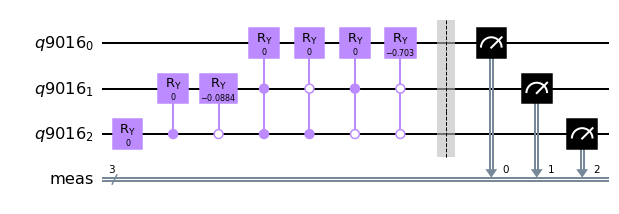

In [41]:
new_qc = QAOA(n_qubits,init_state,eH_mixer,eH_nParticle,opt_var,N)

qc_opt = H_nparticle(n_qubits,basis_states_probs(execute_circuit(new_qc)))
qc_opt.draw(output='mpl')

In [45]:
counts = execute_circuit(qc_opt)
print(cost_Hn(n_qubits,basis_states_probs(counts)))
fig = plot_histogram(counts)

0.014194488525390625


In [47]:
fig.savefig("Graphics/dist_F3.pdf")